In [2]:
import os
import shutil
import numpy as np

import tensorflow as tf
from tensorflow import keras

from pathlib import Path
from IPython.display import display, Audio

DATASET_ROOT = r'D:\Speech Recognition Dataset\train'


AUDIO_SUBFOLDER = "audio"
NOISE_SUBFOLDER = "_background_noise_"

DATASET_AUDIO_PATH = os.path.join(DATASET_ROOT, AUDIO_SUBFOLDER)
DATASET_NOISE_PATH = os.path.join(DATASET_ROOT, NOISE_SUBFOLDER)


VALID_SPLIT = 0.1

SHUFFLE_SEED = 43

SAMPLING_RATE = 16000

SCALE = 0.5

BATCH_SIZE = 128
EPOCHS = 100

In [3]:
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    if subdir != 'README.md':
        subdir_path = DATASET_NOISE_PATH + '\\' + subdir
        noise_paths.append(subdir_path)

In [4]:
noise_paths

['D:\\Speech Recognition Dataset\\train\\_background_noise_\\doing_the_dishes.wav',
 'D:\\Speech Recognition Dataset\\train\\_background_noise_\\dude_miaowing.wav',
 'D:\\Speech Recognition Dataset\\train\\_background_noise_\\exercise_bike.wav',
 'D:\\Speech Recognition Dataset\\train\\_background_noise_\\pink_noise.wav',
 'D:\\Speech Recognition Dataset\\train\\_background_noise_\\running_tap.wav',
 'D:\\Speech Recognition Dataset\\train\\_background_noise_\\white_noise.wav']

In [5]:
command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)
os.system(command)

1

In [6]:
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        print("Sampling rate for {} is incorrect. Ignoring it".format(path))
        return None


noises = []
for path in noise_paths:
    
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} noise files were split into {} noise samples where each is {} sec. long".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

6 noise files were split into 398 noise samples where each is 1 sec. long


In [7]:
#creating 1000 more noise samples so that classifier can be trained on them to predict silence
train_noise = []
for curr in noises:
    train_noise.append(np.array(curr))
for i in range(1000):
    idx1 = np.random.randint(0 , 398)%398
    idx2 = np.random.randint(0 , 398)%398
    train_noise.append(np.array(noises[idx1])*0.5 + np.array(noises[idx2])*0.5)

In [8]:
train_noise = np.array(train_noise)
train_noise.shape

(1398, 16000, 1)

In [9]:
import librosa
import soundfile as sf

In [21]:
#writing noise in audio for training
def write_audio_file(file, data, sample_rate=16000):
        sf.write(file, data, sample_rate, 'PCM_16')

In [22]:
TRAIN_NOISE_DIR = r'D:\Speech Recognition Dataset\train\audio\NOISE'

In [23]:
for i , curr in enumerate(train_noise):
    curr_dir = TRAIN_NOISE_DIR + '\\' + 'sample_' + str(i) + '.wav'
    write_audio_file(curr_dir , curr)

In [68]:
def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio

def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))

def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Create a random tensor of the same size as audio ranging from
        # 0 to the number of noise stream samples that we have.
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Get the amplitude proportion between the audio and the noise
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Adding the rescaled noise to audio
        audio = audio + noise * prop * scale

    return audio

# Get the list of audio file paths along with their corresponding labels

class_names = os.listdir(DATASET_AUDIO_PATH)
print("Our class names: {}".format(class_names,))

req_labels = {'yes':0 , 'no':1 , 'up':2 , 'down':3 , 'left':4 , 'right':5 , 'on':6 , 'off':7 , 'stop':8 , 'go':9 , 'NOISE': 10, 'unknown':11}
audio_paths = []
labels = []
for name in class_names:
    print("Processing speaker {}".format(name,))
    dir_path = Path(DATASET_AUDIO_PATH) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    if name in req_labels:
        labels += [req_labels[name]] * len(speaker_sample_paths)
    else:
        labels += [req_labels['unknown']] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(audio_paths), len(class_names))
)

Our class names: ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin', 'nine', 'no', 'NOISE', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'wow', 'yes', 'zero']
Processing speaker bed
Processing speaker bird
Processing speaker cat
Processing speaker dog
Processing speaker down
Processing speaker eight
Processing speaker five
Processing speaker four
Processing speaker go
Processing speaker happy
Processing speaker house
Processing speaker left
Processing speaker marvin
Processing speaker nine
Processing speaker no
Processing speaker NOISE
Processing speaker off
Processing speaker on
Processing speaker one
Processing speaker right
Processing speaker seven
Processing speaker sheila
Processing speaker six
Processing speaker stop
Processing speaker three
Processing speaker tree
Processing speaker two
Processing speaker up
Processing speaker wow
Processing speaker yes
Processing speaker zero
Fo

In [69]:
set(labels)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [70]:
# Shuffle
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(audio_paths)
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(labels)

# Split into training and validation
num_val_samples = int(VALID_SPLIT * len(audio_paths))
print("Using {} files for training.".format(len(audio_paths) - num_val_samples))
train_audio_paths = audio_paths[:-num_val_samples]
train_labels = labels[:-num_val_samples]

print("Using {} files for validation.".format(num_val_samples))
valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)

#Add noise to the training set
train_ds = train_ds.map(
   lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)

Using 59508 files for training.
Using 6611 files for validation.


In [98]:
from tensorflow.keras.layers import (BatchNormalization, Conv2D, Dense,
                                     Dropout, Flatten, Input, MaxPool2D , Bidirectional, LSTM , Reshape)
from tensorflow.keras.models import Model

In [72]:
_FFT_SIZE = 1024
_HOP_SIZE = 512
_N_MEL_BINS = 128
_N_SPECTROGRAM_BINS = (_FFT_SIZE // 2) + 1
_F_MIN = 0.0
_F_MAX = SAMPLING_RATE / 2

In [73]:
class LogMelSpectrogram(tf.keras.layers.Layer):
    """Compute log-magnitude mel-scaled spectrograms."""

    def __init__(self, sample_rate, fft_size, hop_size, n_mels,
                 f_min=0.0, f_max=None, **kwargs):
        super(LogMelSpectrogram, self).__init__(**kwargs)
        self.sample_rate = sample_rate
        self.fft_size = fft_size
        self.hop_size = hop_size
        self.n_mels = n_mels
        self.f_min = f_min
        self.f_max = f_max if f_max else sample_rate / 2
        self.mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=self.n_mels,
            num_spectrogram_bins=fft_size // 2 + 1,
            sample_rate=self.sample_rate,
            lower_edge_hertz=self.f_min,
            upper_edge_hertz=self.f_max)

    def build(self, input_shape):
        self.non_trainable_weights.append(self.mel_filterbank)
        super(LogMelSpectrogram, self).build(input_shape)

    def call(self, waveforms):
        """Forward pass.
        Parameters
        ----------
        waveforms : tf.Tensor, shape = (None, n_samples)
            A Batch of mono waveforms.
        Returns
        -------
        log_mel_spectrograms : (tf.Tensor), shape = (None, time, freq, ch)
            The corresponding batch of log-mel-spectrograms
        """
        def _tf_log10(x):
            numerator = tf.math.log(x)
            denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
            return numerator / denominator

        def power_to_db(magnitude, amin=1e-16, top_db=80.0):
            """
            https://librosa.github.io/librosa/generated/librosa.core.power_to_db.html
            """
            ref_value = tf.reduce_max(magnitude)
            log_spec = 10.0 * _tf_log10(tf.maximum(amin, magnitude))
            log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref_value))
            log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

            return log_spec

        spectrograms = tf.signal.stft(waveforms,
                                      frame_length=self.fft_size,
                                      frame_step=self.hop_size,
                                      pad_end=False)

        magnitude_spectrograms = tf.abs(spectrograms)

        mel_spectrograms = tf.matmul(tf.square(magnitude_spectrograms),
                                     self.mel_filterbank)

        log_mel_spectrograms = power_to_db(mel_spectrograms)

        # add channel dimension
        log_mel_spectrograms = tf.expand_dims(log_mel_spectrograms, 3)

        return log_mel_spectrograms

    def get_config(self):
        config = {
            'fft_size': self.fft_size,
            'hop_size': self.hop_size,
            'n_mels': self.n_mels,
            'sample_rate': self.sample_rate,
            'f_min': self.f_min,
            'f_max': self.f_max,
        }
        config.update(super(LogMelSpectrogram, self).get_config())

        return config

In [74]:
def ConvModel(n_classes, sample_rate=16000, duration=1,
              fft_size=_FFT_SIZE, hop_size=_HOP_SIZE, n_mels=_N_MEL_BINS):
    n_samples = sample_rate * duration
    input_shape = (n_samples,)

    x = Input(shape=input_shape, name='input', dtype='float32')    
    y = LogMelSpectrogram(sample_rate, fft_size, hop_size, n_mels)(x)
    
    # data normalization (on frequency axis)
    y = BatchNormalization(axis=2)(y)
    
    # effectively 1D convolution, since kernel spans entire frequency-axis
    y = Conv2D(32, 3, activation='relu')(y)
    y = BatchNormalization()(y)
    y = Conv2D(64, 3, activation = 'relu')(y)
    y = BatchNormalization()(y)
    y = MaxPool2D()(y)
    y = Conv2D(32, (3, 1), activation='relu')(y)
    y = BatchNormalization()(y)
    y = MaxPool2D(pool_size=(2, 1))(y)
    y = Dropout(0.25)(y)
    y = Flatten()(y)
    y = Dense(128, activation='relu')(y)
    y = Dropout(0.25)(y)
    y = Dense(n_classes, activation='softmax')(y)

    return Model(inputs=x, outputs=y)

In [115]:
def CNN_RNN(n_classes, sample_rate=16000, duration=1,
              fft_size=_FFT_SIZE, hop_size=_HOP_SIZE, n_mels=_N_MEL_BINS):
    n_samples = sample_rate * duration
    input_shape = (n_samples,)
    x = Input(shape=input_shape, name='input', dtype='float32')
    y = LogMelSpectrogram(sample_rate, fft_size, hop_size, n_mels)(x)
    y = BatchNormalization(axis=2)(y)
    y = Conv2D(32, 3, activation='relu')(y)
    y = BatchNormalization()(y)
    y = Conv2D(64, 3, activation = 'relu')(y)
    y = BatchNormalization()(y)
    y = MaxPool2D((1 , 3))(y)
    y = Conv2D(128, 3, activation='relu')(y)
    y = BatchNormalization()(y)
    y = MaxPool2D(pool_size=(1, 3))(y)
    y = Dropout(0.25)(y)
    y = Reshape((y.shape[1],y.shape[2]*y.shape[3]))(y)
    y = Bidirectional(LSTM(128 , return_sequences=False))(y)
    y = Dropout(0.25)(y)
    y = Dense(256, activation='relu')(y)
    y = Dropout(0.25)(y)
    y = Dense(n_classes, activation='softmax')(y)

    
    return Model(inputs=x, outputs=y)

In [75]:
model = ConvModel(12)

print(model.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 16000)]           0         
_________________________________________________________________
log_mel_spectrogram_3 (LogMe (None, 30, 128, 1)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 30, 128, 1)        512       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 126, 32)       320       
_________________________________________________________________
batch_normalization_13 (Batc (None, 28, 126, 32)       128       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 26, 124, 64)       18496     
_________________________________________________________________
batch_normalization_14 (Batc (None, 26, 124, 64)       256 

In [76]:
# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=['accuracy']
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model2.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True, mode = 'max'
)

In [77]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [78]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
    verbose = 2
)

Epoch 1/100
465/465 - 218s - loss: 1.0147 - accuracy: 0.7004 - val_loss: 0.6957 - val_accuracy: 0.7810
Epoch 2/100
465/465 - 49s - loss: 0.5373 - accuracy: 0.8236 - val_loss: 0.4358 - val_accuracy: 0.8583
Epoch 3/100
465/465 - 49s - loss: 0.4049 - accuracy: 0.8654 - val_loss: 0.3815 - val_accuracy: 0.8808
Epoch 4/100
465/465 - 49s - loss: 0.3193 - accuracy: 0.8938 - val_loss: 0.3589 - val_accuracy: 0.8929
Epoch 5/100
465/465 - 50s - loss: 0.2703 - accuracy: 0.9098 - val_loss: 0.2955 - val_accuracy: 0.9073
Epoch 6/100
465/465 - 49s - loss: 0.2378 - accuracy: 0.9201 - val_loss: 0.2888 - val_accuracy: 0.9095
Epoch 7/100
465/465 - 49s - loss: 0.2095 - accuracy: 0.9298 - val_loss: 0.3169 - val_accuracy: 0.9124
Epoch 8/100
465/465 - 49s - loss: 0.1886 - accuracy: 0.9366 - val_loss: 0.2791 - val_accuracy: 0.9180
Epoch 9/100
465/465 - 49s - loss: 0.1679 - accuracy: 0.9432 - val_loss: 0.2685 - val_accuracy: 0.9269
Epoch 10/100
465/465 - 50s - loss: 0.1562 - accuracy: 0.9478 - val_loss: 0.2767 -

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


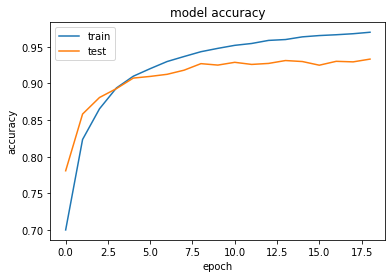

In [80]:
# list all data in history
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

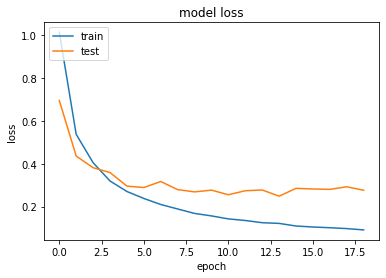

In [81]:
# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [82]:
DATASET_TEST_DIR = r'D:\Speech Recognition Dataset\test\test\audio'

In [83]:
test_audio_paths = []
for file in os.listdir(DATASET_TEST_DIR):
    file_dir = DATASET_TEST_DIR + '\\' + file
    if file_dir.endswith(".wav"):
        test_audio_paths += [file_dir]
print(
    "Found {} files belonging to test.".format(len(test_audio_paths))
)

Found 158538 files belonging to test.


In [84]:
def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio

def paths_to_dataset(audio_paths):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    return audio_ds

In [85]:
test_ds = paths_to_dataset(test_audio_paths).batch(BATCH_SIZE)

In [86]:
y_pred = model.predict(test_ds)

In [87]:
y_pred.shape

(158538, 12)

In [88]:
Y = []
for i in y_pred:
    Y.append(np.argmax(np.array(i)))

In [89]:
Y

[1,
 11,
 11,
 10,
 11,
 11,
 6,
 11,
 9,
 11,
 11,
 11,
 11,
 0,
 1,
 8,
 11,
 3,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 7,
 10,
 3,
 11,
 11,
 11,
 8,
 3,
 11,
 3,
 0,
 10,
 11,
 6,
 11,
 11,
 11,
 11,
 11,
 0,
 1,
 1,
 11,
 11,
 11,
 2,
 1,
 11,
 1,
 11,
 11,
 11,
 10,
 11,
 8,
 11,
 2,
 11,
 6,
 11,
 0,
 11,
 11,
 11,
 11,
 11,
 11,
 10,
 11,
 1,
 11,
 11,
 11,
 1,
 11,
 11,
 11,
 11,
 11,
 3,
 1,
 7,
 10,
 11,
 4,
 11,
 11,
 7,
 11,
 9,
 11,
 11,
 11,
 10,
 11,
 11,
 3,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 3,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 6,
 6,
 5,
 11,
 11,
 11,
 11,
 4,
 11,
 7,
 7,
 11,
 11,
 11,
 8,
 11,
 11,
 11,
 11,
 8,
 11,
 11,
 11,
 11,
 5,
 6,
 11,
 11,
 0,
 11,
 0,
 11,
 11,
 11,
 9,
 11,
 11,
 11,
 4,
 11,
 10,
 11,
 11,
 7,
 11,
 11,
 11,
 11,
 11,
 10,
 11,
 11,
 8,
 11,
 0,
 11,
 11,
 11,
 11,
 8,
 8,
 7,
 11,
 11,
 11,
 4,
 10,
 11,
 10,
 11,
 2,
 6,
 11,
 11,
 11,
 7

In [90]:
id_labels = {0:'yes' , 1:'no' , 2:'up', 3:'down' , 4:'left' , 5:'right' , 6:'on' , 7:'off' , 8:'stop', 9:'go' , 10:'silence' , 11:'unknown'}
X = []
for i , path in enumerate(test_audio_paths):
    X.append([path.split('\\')[-1] , id_labels[Y[i]]])

In [91]:
import csv
with open("out3.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(X)

In [118]:
model2 = CNN_RNN(12 , n_mels = 256)
model2.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 16000)]           0         
_________________________________________________________________
log_mel_spectrogram_17 (LogM (None, 30, 256, 1)        0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 30, 256, 1)        1024      
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 28, 254, 32)       320       
_________________________________________________________________
batch_normalization_66 (Batc (None, 28, 254, 32)       128       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 26, 252, 64)       18496     
_________________________________________________________________
batch_normalization_67 (Batc (None, 26, 252, 64)       256 

In [119]:
# Compile the model using Adam's default learning rate
model2.compile(
    optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=['accuracy']
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model3.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True, mode = 'max'
)

In [120]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [121]:
history2 = model2.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
    verbose = 2
)

Epoch 1/100
465/465 - 795s - loss: 0.7070 - accuracy: 0.7853 - val_loss: 0.3584 - val_accuracy: 0.8863
Epoch 2/100
465/465 - 399s - loss: 0.3286 - accuracy: 0.8947 - val_loss: 0.2377 - val_accuracy: 0.9251
Epoch 3/100
465/465 - 195s - loss: 0.2609 - accuracy: 0.9164 - val_loss: 0.2186 - val_accuracy: 0.9319
Epoch 4/100
465/465 - 146s - loss: 0.2210 - accuracy: 0.9298 - val_loss: 0.1827 - val_accuracy: 0.9424
Epoch 5/100
465/465 - 148s - loss: 0.1886 - accuracy: 0.9401 - val_loss: 0.1711 - val_accuracy: 0.9483
Epoch 6/100
465/465 - 149s - loss: 0.1742 - accuracy: 0.9442 - val_loss: 0.1626 - val_accuracy: 0.9507
Epoch 7/100
465/465 - 148s - loss: 0.1559 - accuracy: 0.9503 - val_loss: 0.1481 - val_accuracy: 0.9546
Epoch 8/100
465/465 - 149s - loss: 0.1491 - accuracy: 0.9518 - val_loss: 0.1481 - val_accuracy: 0.9560
Epoch 9/100
465/465 - 151s - loss: 0.1408 - accuracy: 0.9554 - val_loss: 0.1435 - val_accuracy: 0.9557
Epoch 10/100
465/465 - 147s - loss: 0.1288 - accuracy: 0.9587 - val_loss:

KeyboardInterrupt: 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


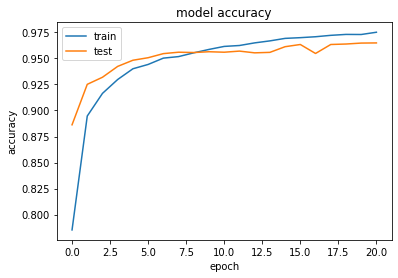

In [123]:
# list all data in history
print(model2.history.history.keys())
# summarize history for accuracy
plt.plot(model2.history.history['accuracy'])
plt.plot(model2.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

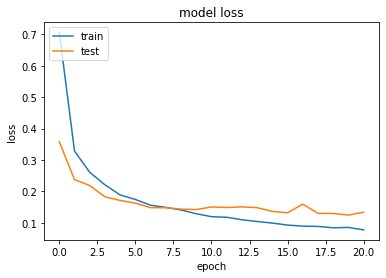

In [124]:
# summarize history for loss
plt.plot(model2.history.history['loss'])
plt.plot(model2.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [125]:
y_pred2 = model2.predict(test_ds)

In [128]:
y_pred2.shape

(158538, 12)

In [131]:
Y2 = []
for i in y_pred2:
    Y2.append(np.argmax(np.array(i)))

In [132]:
Y2

[1,
 11,
 11,
 2,
 11,
 11,
 11,
 11,
 9,
 11,
 7,
 11,
 11,
 0,
 1,
 8,
 11,
 3,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 7,
 10,
 3,
 11,
 11,
 11,
 8,
 3,
 11,
 3,
 4,
 11,
 11,
 6,
 11,
 11,
 11,
 11,
 11,
 0,
 1,
 1,
 11,
 11,
 11,
 2,
 9,
 11,
 1,
 11,
 11,
 11,
 10,
 11,
 8,
 11,
 2,
 11,
 7,
 11,
 4,
 11,
 11,
 10,
 11,
 11,
 11,
 10,
 11,
 1,
 11,
 11,
 11,
 1,
 11,
 11,
 11,
 11,
 11,
 3,
 1,
 7,
 10,
 11,
 4,
 11,
 11,
 7,
 11,
 9,
 11,
 11,
 11,
 10,
 11,
 11,
 3,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 3,
 10,
 11,
 11,
 5,
 11,
 11,
 11,
 11,
 1,
 11,
 1,
 11,
 11,
 10,
 11,
 2,
 11,
 11,
 11,
 11,
 2,
 11,
 11,
 11,
 6,
 6,
 11,
 11,
 11,
 11,
 11,
 4,
 9,
 7,
 7,
 11,
 11,
 11,
 8,
 11,
 11,
 1,
 11,
 8,
 11,
 11,
 11,
 11,
 5,
 7,
 11,
 11,
 0,
 11,
 0,
 11,
 1,
 11,
 11,
 11,
 11,
 11,
 4,
 11,
 10,
 11,
 11,
 2,
 11,
 11,
 11,
 11,
 11,
 10,
 11,
 11,
 8,
 11,
 0,
 11,
 11,
 11,
 11,
 8,
 8,
 2,
 11,
 8,
 11,
 4,
 10,
 11,
 10,
 11,
 2,
 6,
 11,
 11,
 6,
 11,
 11,
 

In [133]:
id_labels = {0:'yes' , 1:'no' , 2:'up', 3:'down' , 4:'left' , 5:'right' , 6:'on' , 7:'off' , 8:'stop', 9:'go' , 10:'silence' , 11:'unknown'}
X2 = []
for i , path in enumerate(test_audio_paths):
    X2.append([path.split('\\')[-1] , id_labels[Y2[i]]])

In [136]:
import csv
with open("out5.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(X2)

In [137]:
from tensorflow.keras.models import load_model

In [139]:
algo1 = ConvModel(12)

In [141]:
algo1.load_weights('model2.h5')

In [ ]:
algo1.